# Задание

Вам предстоит поработать с данными о стабильности белков (`tm`). Нужно по последовательности белка и по `pH` предсказывать стабильность. Так как это дополнительное задание, то комментариев и подробного плана не будет, вам нужно максимально показать свои знания и постараться добиться наилучшего качества.

Небольшой план для начала:

1. Провести небольшой EDA, найти возможные выбросы и понять, в чем может быть дело.
2. Придумать, как закодировать аминокислотные последовательности в числовые векторы.
3. Разделить данные на `train` и `test` (подумать над правильной стратегией разбиения).
4. Используя кросс-вадидацию подобрать наилучшую модель на тренировочных данных.
5. Обучить лучшую модель на всех тренировочных данных.
5. Протестировать лучшую модель на тестовых данных.

Оформить подробный отчет в виде ноутбука. Постарайтесь воспользоваться всеми техниками, которые мы прошли в курсе.

*Так как текущее задание в довольно свободной форме, то четких критериев оценки нет. Если минимально проследовать вышеуказанным рекомендациям, то можно получить до **20 баллов**. Максимально за это задание можно получить **40***.

In [1]:
!nvidia-smi

Sun May 21 08:59:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from os.path import join
import pandas as pd
import seaborn as sns
import os
import glob

import numpy as np
import torch
from tqdm import tqdm
import gc
from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch.cuda as cuda

In [3]:
!wget https://raw.githubusercontent.com/danon6868/BI-ml-2023/main/additional_homework/data/data.csv

--2023-05-21 08:59:30--  https://raw.githubusercontent.com/danon6868/BI-ml-2023/main/additional_homework/data/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15460093 (15M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]  14.74M  --.-KB/s    in 0.1s    

2023-05-21 08:59:31 (138 MB/s) - ‘data.csv’ saved [15460093/15460093]



In [4]:
!pip3 install wldhx.yadisk-direct

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# EDA

In [5]:
data_folder = "./"
data_filename = "data.csv"
data_path = join(data_folder, data_filename)

In [6]:
data = pd.read_csv(data_path, index_col=0)
data.head()

,protein_sequence,pH,data_source,tm
seq_id,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


In [7]:
data.shape

(31390, 4)

## Ph

In [8]:
data.describe()

,pH,tm
count,31104.000000,31390.000000
mean,6.892339,49.147337
std,1.612225,14.010089
min,1.990000,-1.000000
25%,7.000000,42.100000
50%,7.000000,48.000000
75%,7.000000,53.800000
max,64.900000,130.000000


Уже тут видим, что некоторые pH значения не заполнены

In [9]:
data[data.pH.isna()].head(10)

,protein_sequence,pH,data_source,tm
seq_id,,,,
484,ARINTVRGPITISEAGFTLTHEHICGSSAGFLRAWPEFFGSRKALA...,NaN,10.1016/j.jmb.2013.06.028,84.0
6215,MASHKLLVTPLKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,73.8
6216,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,85.5
6217,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,67.1
6218,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,83.2
6219,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,84.1
6220,MASHKLLVTPPKALLKPLSIPNQLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,84.4
6226,MASHKLLVTPPKALLKPLSIPNRLLLGPGPSNLPPRIMAAGGLQMI...,NaN,10.1016/j.bbapap.2014.10.010,84.5
12926,MIRTGTQYLESLNDGRNVWVGNEKIDNVATHPKTRDYAQRHADFYD...,NaN,10.1002/cbic.201900413,50.0


Оставим только записи, в которых есть pH

In [10]:
data = data[~data.pH.isna()]

<Axes: xlabel='pH'>

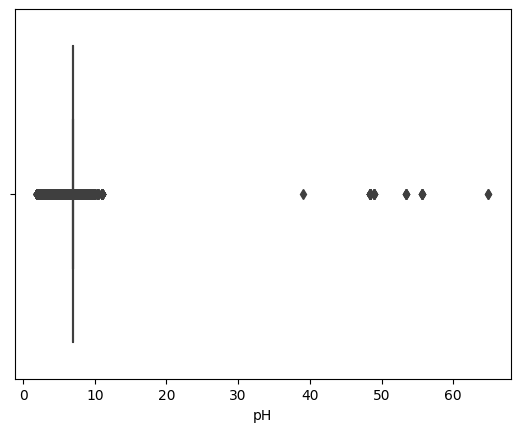

In [11]:
sns.boxplot(x=data.pH)

Избавимся от выбросов по pH. Более того, pH более 14 достаточно сложно интерпретировать, и не встречается в большинстве живих систем, где эти белки могут проявлять активность

In [12]:
data = data[data.pH<14]

<Axes: xlabel='pH'>

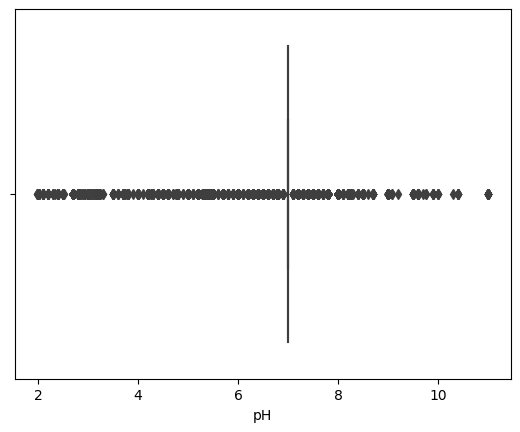

In [13]:
sns.boxplot(x=data.pH)

<Axes: xlabel='tm'>

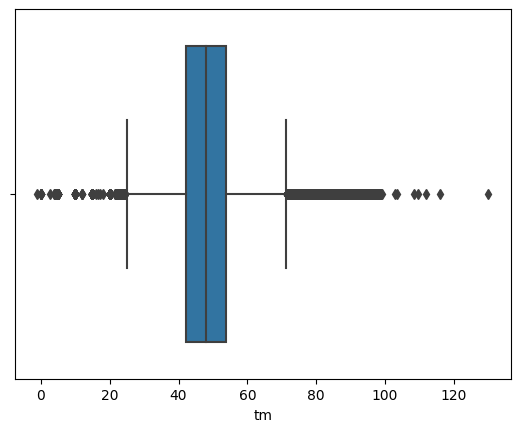

In [14]:
sns.boxplot(x=data.tm)

## Length

Посмотрим на длины последовательностей

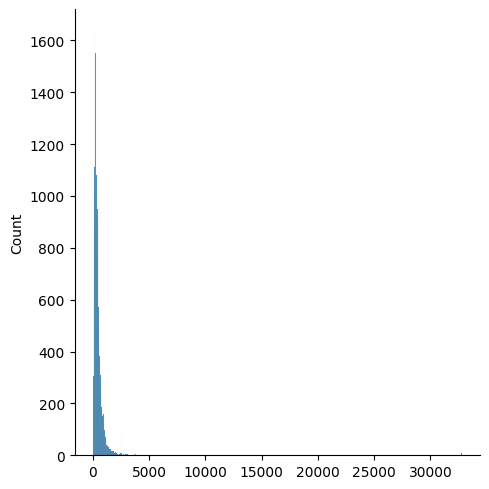

In [15]:
seq_lens = [len(seq) for seq in data.protein_sequence.unique()]
sns.displot(seq_lens)

Избавимся от очень длинных последовательностей, тк их очень мало и они могут сильно повлиять на работу модели

In [16]:
# сколько записей уберём из наших данных
(data.protein_sequence.apply(lambda x: len(x)) > 3000).sum()

93

In [17]:
data = data[data.protein_sequence.apply(lambda x: len(x)) < 3000]

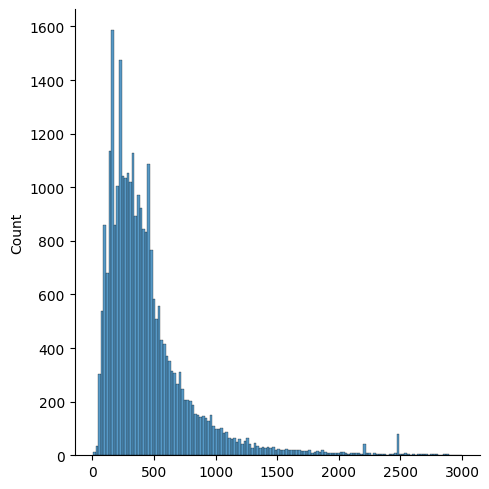

In [18]:
seq_lens = [len(seq) for seq in data.protein_sequence.unique()]
sns.displot(seq_lens)

Уберём ещё последовательностей, который длиннее 2000

In [19]:
data = data[data.protein_sequence.apply(lambda x: len(x)) < 2000]

In [20]:
data = data.loc[data.protein_sequence.apply(lambda x: len(x)).sort_values().index]

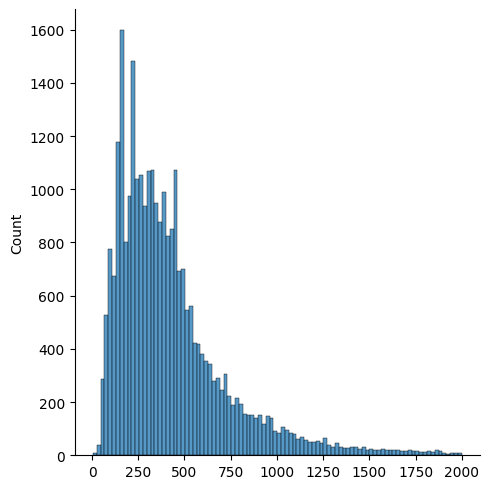

In [21]:
seq_lens = [len(seq) for seq in data.protein_sequence.unique()]
sns.displot(seq_lens)

In [22]:
data_df = data.reset_index(drop=True)
data_df

,protein_sequence,pH,data_source,tm
0,RPAVT,7.0,doi.org/10.1038/s41592-020-0801-4,50.4
1,RPGSI,7.0,doi.org/10.1038/s41592-020-0801-4,49.2
2,TVIHLVG,7.0,doi.org/10.1038/s41592-020-0801-4,44.4
3,LVVGTALNYINIF,7.0,doi.org/10.1038/s41592-020-0801-4,58.3
4,SCQGTGKDSHSFSS,7.0,doi.org/10.1038/s41592-020-0801-4,37.7
...,...,...,...,...
30621,MEERKQETTNQAHVLFDRFVQATTCKGTLRAFQELCDHLELKPKDY...,7.0,doi.org/10.1038/s41592-020-0801-4,50.4
30622,MALTVCVRHLTGLPGTHDRQVRLCFRGFTQKTRKIHCGREADVGEL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.7
30623,AHPPEIIRKPQNQGVRVGGVASFYCAARGDPPPSIVWRKNGKKVSG...,7.0,doi.org/10.1038/s41592-020-0801-4,45.8
30624,MAAVTMSVSGRKVASRPGPVPEAAQSFLYAPRTPNVGGPGGPQVEW...,7.0,doi.org/10.1038/s41592-020-0801-4,52.4


# AA to numbers

Воспользуемся ESM эмбеддингами

In [138]:
def get_esm_embeddings(model, alphabet, batch_converter, data, device):
    gc.collect()
    model.eval()
    model.to(device)
    
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    batch_tokens = batch_tokens.to(device)
    
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]
    
    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0).to("cpu").numpy())
        
    del batch_tokens
    del results
    del token_representations
    return sequence_representations

In [139]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")

Downloading: "https://github.com/facebookresearch/esm/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [ ]:
model()

In [140]:
data_list = [(f"protein_{i}", data_df["protein_sequence"][i]) for i in range(data_df.shape[0])]

In [141]:
batch_converter = alphabet.get_batch_converter()
batch_size = 1
num_iter = np.ceil(len(data_list) / batch_size).astype(int)
sequence_embeddings = []

for i in tqdm(range(29200, num_iter)):
    sequence_representations = get_esm_embeddings(model,
                                                  alphabet,
                                                  batch_converter,
                                                  data_list[i*batch_size:(i+1)*batch_size],
                                                  device="cuda")
    
    sequence_embeddings += sequence_representations
    cuda.empty_cache()

 79%|███████▉  | 1125/1426 [15:09<04:03,  1.24it/s]


OutOfMemoryError: ignored

In [142]:
sequence_embeddings_np = np.array(sequence_embeddings)

In [143]:
sequence_embeddings_np

array([[-0.00195319, -0.02966277,  0.02380939, ..., -0.05877241,
         0.02486461,  0.09963807],
       [ 0.00215372, -0.05350533, -0.00112378, ..., -0.1277917 ,
         0.07098053,  0.13060698],
       [-0.00348198, -0.12215555,  0.04244434, ..., -0.03544644,
         0.11937127,  0.10187543],
       ...,
       [-0.00277045,  0.00078549,  0.00167371, ..., -0.00024179,
         0.02117544,  0.13203977],
       [-0.01707195, -0.03551016, -0.02798375, ..., -0.1626782 ,
        -0.02670707,  0.11488622],
       [ 0.03287724, -0.00032899,  0.04210863, ..., -0.08037309,
        -0.0161797 ,  0.04101064]], dtype=float32)

In [145]:
sequence_embeddings_np.tofile('5_embeddings_29200_30325.txt')

# Embeddings checkout

In [23]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/osVSNm2SxzjukQ) -o 1_embeddings_0_5000.txt
!curl -L $(yadisk-direct https://disk.yandex.ru/d/biUoIR8lgYuPWg) -o 2_embeddings_5000_28570.txt
!curl -L $(yadisk-direct https://disk.yandex.ru/d/JTjQtfKvz_DOag) -o 3_embeddings_28570_29000.txt
!curl -L $(yadisk-direct https://disk.yandex.ru/d/M9gug9vE5ejJ_Q) -o 4_embeddings_29000_29200.txt 
!curl -L $(yadisk-direct https://disk.yandex.ru/d/l8Le1Gy-ls1RiQ) -o 5_embeddings_29200_30325.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 24.4M  100 24.4M    0     0  6197k      0  0:00:04  0:00:04 --:--:--  9.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  115M  100  115M    0     0  15.1M      0  0:00:07  0:00:07 --:--:-- 22.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2150k  100 2150k    0     0   865k      0  0:00:02  0:00:02 --:--:-- 2580k
  % Total    % Received % Xferd  Average Speed   Tim

Загрузим дампы итераций расчёта эмбеддингов

In [58]:
data_pre_list = []
embeddings_pre_list = []
paths=[path for path in glob.glob('*_embeddings_*.txt')]
paths = sorted(paths)

for path in paths:
  print(path)
  tmp_parse = path[:-4].split('_')
  start, end = int(tmp_parse[-2]), int(tmp_parse[-1])
  tmp_np = np.fromfile(path, dtype='float32')
  tmp_np = tmp_np.reshape(end-start, 1280)

  embeddings_pre_list.append(tmp_np)
  data_pre_list.append(data_df.iloc[start:end])

data_df_new = pd.concat(data_pre_list)

embeddings = np.concatenate(
    (
        np.concatenate(embeddings_pre_list, axis=0),
        data_df_new[['pH']].values
     ), axis=1
     )



1_embeddings_0_5000.txt
2_embeddings_5000_28570.txt
3_embeddings_28570_29000.txt
4_embeddings_29000_29200.txt
5_embeddings_29200_30325.txt


In [60]:
data_df_new.data_source = data_df_new.data_source.fillna('nan')

# PCA check

In [148]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [149]:
pca = PCA(n_components=2).fit(StandardScaler().fit_transform(embeddings[:, :-1]))

In [150]:
embeddings_transfomed = pca.fit_transform(embeddings[:, :-1])

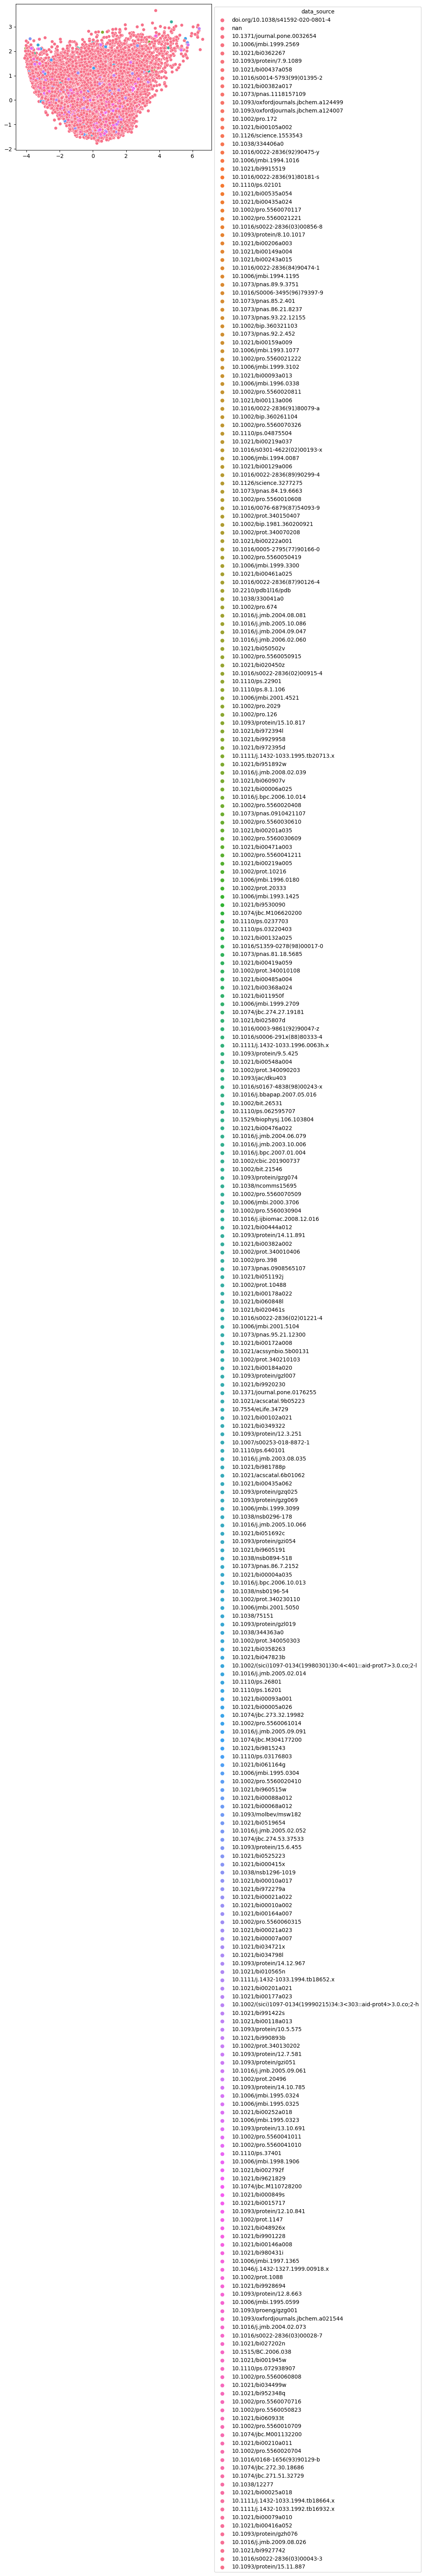

In [151]:
ax = sns.scatterplot(x=embeddings_transfomed[:, 0], 
                y=embeddings_transfomed[:, 1], 
                hue=data_df_new["data_source"],
                # legend=False
                );
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

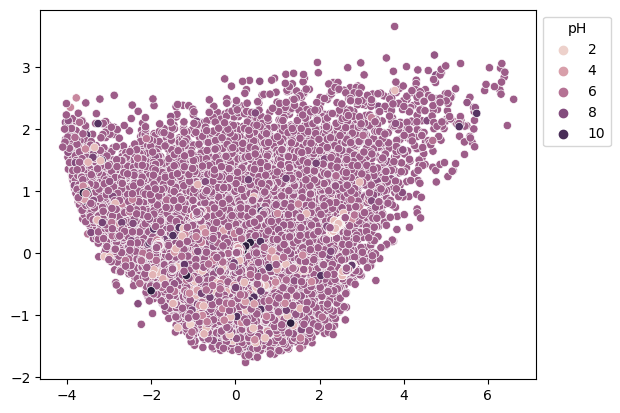

In [152]:
ax = sns.scatterplot(x=embeddings_transfomed[:, 0], 
                y=embeddings_transfomed[:, 1], 
                hue=data_df_new["pH"],
                # legend=False
                );
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

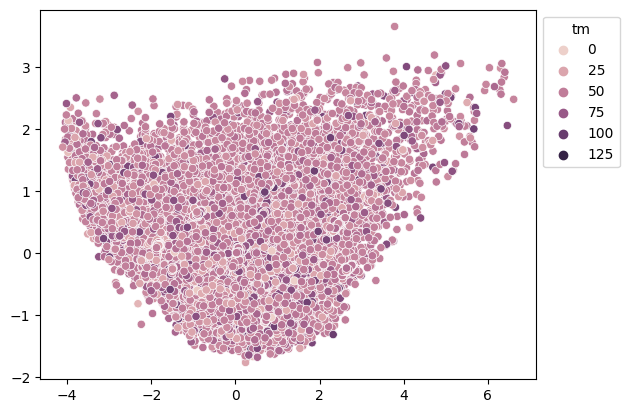

In [153]:
ax = sns.scatterplot(x=embeddings_transfomed[:, 0], 
                y=embeddings_transfomed[:, 1], 
                hue=data_df_new["tm"],
                # legend=False
                );
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Train-test split

Очевидно, что нам нужно положить измерения для одного и того же белка либо в train, либо в test

In [61]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm

In [62]:
def custom_train_test_split(data_df, embeddings, test_size=0.2, random_state=42):

  data_cumsum = data_df.protein_sequence.value_counts().sample(frac=1, random_state=random_state).cumsum()
  test_proteins = data_cumsum[data_cumsum<test_size*data_cumsum[-1]].index
  test_mask = data_df.protein_sequence.isin(test_proteins).values

  X_test = embeddings[test_mask]
  X_train = embeddings[~test_mask]
  y_test = data_df.tm[test_mask].values
  y_train = data_df.tm[~test_mask].values

  return X_train, X_test, y_train, y_test

In [63]:
mask = (data_df_new.data_source!='nan').values

In [64]:
X_train, X_test, y_train, y_test = custom_train_test_split(
    data_df_new,#[mask], 
    embeddings#[mask]
    )

# Model train

## LGBMRegressor

In [31]:
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import get_scorer_names

Обучим регрессор LGBMRegressor, подобрав оптимальные параметры с помощью GridSearchCV

In [263]:
params = {
    "num_leaves": [20, 31, 40, 50],
    'max_depth': [-1, 15, 20, 30, 50], 
    'n_estimators': [50, 100, 200], #, 300, 400]
}

lgbm_model = lightgbm.LGBMRegressor(random_state=42)

rf_search = GridSearchCV(lgbm_model, params, scoring = 'neg_mean_squared_error', cv = 5, n_jobs=-1, verbose=10)

rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [-1, 15, 20, 30, 50],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [20, 31, 40, 50]},
             scoring='neg_mean_squared_error', verbose=10)

In [264]:
max(rf_search.cv_results_['mean_test_score'])

-197.62333950358993

In [265]:
rf_search.best_params_

{'max_depth': -1, 'n_estimators': 50, 'num_leaves': 20}

In [72]:
model = lightgbm.LGBMRegressor(
    random_state=42, 
    n_jobs=-1,
    max_depth = -1,
    n_estimators = 50, 
    num_leaves = 20,
    ).fit(X_train, y_train)

In [73]:
cv = KFold()

In [74]:
cross_val_score(model,
                X_train,
                y_train,
                cv=cv,
                scoring="neg_mean_squared_error")

array([-315.08736953, -256.34699511, -174.03764102, -157.37630909,
       -109.08367818])

In [75]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [76]:
metric_train = mean_squared_error(y_train, y_train_pred)
metric_test = mean_squared_error(y_test, y_test_pred)

In [77]:
print(f'{metric_train=}', f'{metric_test=}')

metric_train=144.73794549352957 metric_test=163.41211660607462


In [78]:
import matplotlib.pyplot as plt

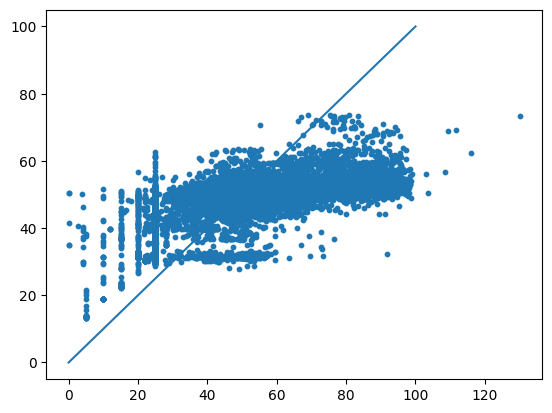

In [79]:
plt.scatter(y_train, y_train_pred, s=10)
plt.plot([0,100], [0, 100])

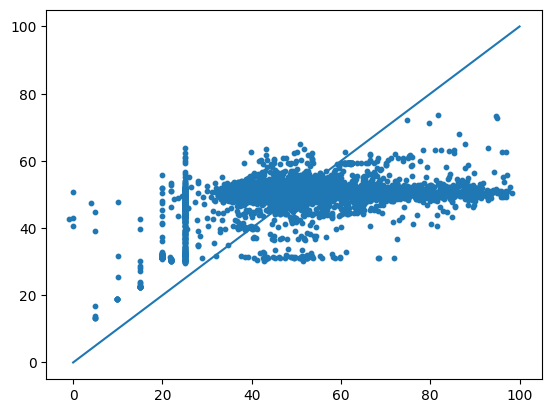

In [80]:
plt.scatter(y_test, y_test_pred, s=10)
plt.plot([0,100], [0, 100])